In [1]:
import os
import json
import re
import random
from datetime import datetime


import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist

import gensim
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim import models, corpora, similarities
from gensim.parsing.preprocessing import preprocess_string
from gensim.utils import tokenize, simple_preprocess


import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
import seaborn as sns

# Enable logging for gensim - optional

import warnings
warnings.filterwarnings("ignore")

# import dependencies
%matplotlib inline

random.seed(12)

In [41]:
# Fetch the article data
df = pd.read_json('data/dataset.json')
df.head()

,body,categories,description,id,mainCategory,published,subCategory,title,type,venue
0,Vuonna 1978 valmistuneen mökin lautaverhoilu o...,[Mökit],Suvin ja Kallen mökki on niin lähellä perheen ...,QXJ0aWNsZTpjZDUwZDI5Mi1jYjk5LTRlZmYtYWVmNC0yZm...,Meidän Mökki,1550043116000,Sisustus,Makkaranpaistoa tulipadassa ja lämpimänä höyry...,Article,meillakotona
1,Yrittäjäpariskunta Anu ja Heikki asuvat Rymätt...,"[Keittiö, Keittiöremontti]","Anu ja Heikki halusivat laadukkaan keittiön, j...",QXJ0aWNsZTo5OTQ0MjNkYy04ZTljLTQxZTItOGQyNy0xMT...,Avotakka,1549969080000,Sisustus,Hirsitalon keittiö remontoitiin tähän päivään ...,Article,meillakotona
2,Sirpan koti sijaitsee vuonna 1907 rakennetussa...,"[Kodit, Skandinaavinen sisustus]","Kun arvostaa elämän pieniä nautintoja, taidett...",QXJ0aWNsZTplNGZiM2EwOS01MTI2LTRkYTctYjEzOS1jYz...,Avotakka,1549960923000,Sisustus,Jugendtalon rappukäytävä lumosi Sirpan – koti ...,Article,meillakotona
3,Moderni hirsitalo\r\nAsukkaat: sisustussuunnit...,"[Rakentaminen, Hirsitalo]","Moderni hirsitalo, entinen perhekoti ja muutto...",QXJ0aWNsZTphOTQyMzU3YS01OGRkLTQ2ZTQtOGIyNC1hZW...,Meidän Talo,1549959061000,Rakenna ja remontoi,Haaveena oma talo? Lue kolme erilaista tarinaa...,Article,meillakotona
4,"Saarekkeen ääressä on kiva juoda aamukahvit, n...","[Kodit, Ennen ja jälkeen, Keittiöremontti, Rem...",Kun Satu ja Kyösti Melametsä rakennuttivat per...,QXJ0aWNsZTpkZDllOTM3ZS1iZWE3LTQxMDEtODAwNS00MT...,Meidän Talo,1549956919000,Rakenna ja remontoi,Keittiöremontti käynnisti ketjureaktion! Teini...,Article,meillakotona


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 10 columns):
body            7303 non-null object
categories      7303 non-null object
description     7303 non-null object
id              7303 non-null object
mainCategory    7303 non-null object
published       7303 non-null int64
subCategory     7303 non-null object
title           7303 non-null object
type            7303 non-null object
venue           7303 non-null object
dtypes: int64(1), object(9)
memory usage: 570.6+ KB


In [43]:
# Global Constant
LANG = 'finnish'
N_TOPICS = 30
MIN_DOC_LEN = 50

# Data Preprocessing

This task included text cleaning, stop word removing and tokenization

In [44]:
def clean_text(text):
    """
    clean text of websites, email addresess and any punctuation, and word less than 3 chars
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    tokens = simple_preprocess(text, deacc=False, min_len=3)

    return list(tokens)

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    stop_words = []
    with open('data/stopwords-fi.json', 'r') as f:
        stop_words = json.load(f)
        
    return [word for word in text if word not in stop_words]


def apply_all(text):
    """
    This function applies all the functions above into one
    We realize that stemming would decrease the model performance so not using them
    """
    return remove_stop_words(clean_text(text))

def preprocessing(df):
    # copy df
    new_df = pd.DataFrame(df)
    
    # join category to string as keywords
    new_df['keywords'] = new_df['categories'].apply(lambda x: " ".join(x))
    
    # clean text and title and create new column "tokenized"
    new_df['tokenized'] = new_df['body'].apply(apply_all) \
                            + new_df['title'].apply(apply_all) \
                            + new_df['description'].apply(apply_all) \
                            + new_df['keywords'].apply(apply_all)
    
    return new_df

In [45]:
%%time

# apply preprocessing and save to the df
df = preprocessing(df)

print("Time to clean and tokenize", len(df), "articles:")

Time to clean and tokenize 7303 articles:
CPU times: user 1min 10s, sys: 256 ms, total: 1min 10s
Wall time: 1min 10s


In [46]:
# save the data
df.to_json('data/data_cleaned.json', orient="records")

In [47]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = df['doc_len']

print("length of list:",len(doc_lengths),
      "\naverage document length", doc_lengths.mean(),
      "\nminimum document length", doc_lengths.min(),
      "\nmaximum document length", doc_lengths.max(),
      "\nnumber document less than {} words:".format(MIN_DOC_LEN), (doc_lengths < MIN_DOC_LEN).sum())

#df.drop(labels='doc_len', axis=1, inplace=True)

length of list: 7303 
average document length 284.06791729426266 
minimum document length 10 
maximum document length 3316 
number document less than 50 words: 285


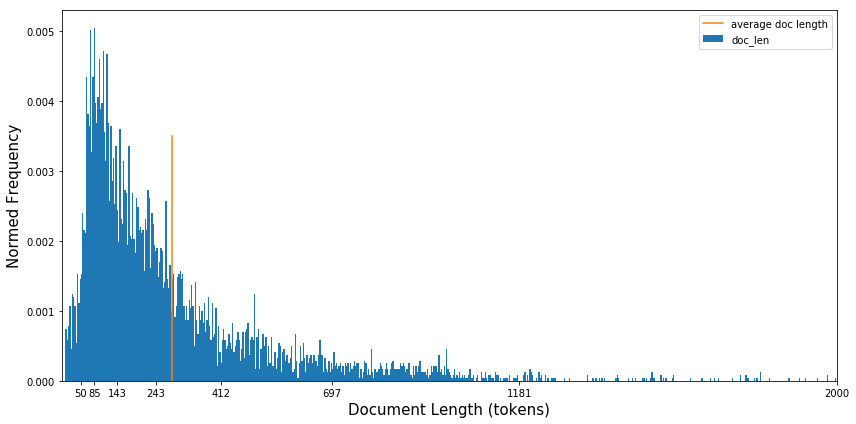

In [13]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [28]:
# remove the document has length less than minimum chars
df_train = df[df['doc_len'] > MIN_DOC_LEN]

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7005 entries, 0 to 7302
Data columns (total 12 columns):
body            7005 non-null object
categories      7005 non-null object
description     7005 non-null object
doc_len         7005 non-null int64
keywords        7005 non-null object
mainCategory    7005 non-null object
published       7005 non-null int64
subCategory     7005 non-null object
title           7005 non-null object
tokenized       7005 non-null object
type            7005 non-null object
venue           7005 non-null object
dtypes: int64(2), object(10)
memory usage: 711.4+ KB


In [8]:
def create_dictionary(tokens, no_below=5, no_above=0.2):
    # Those most freq words or rare word will not contribute to the topic of whole corpus much.
    # So we will filter them, the word exist in less than 5 docs or appear in above 30% of all docs
    dictionary = corpora.Dictionary(df['tokenized'], )
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    return dictionary

In [17]:
%%time
# now we need to create dictionary format for the corpus
dictionary = create_dictionary(df['tokenized'])

CPU times: user 2.68 s, sys: 36 ms, total: 2.72 s
Wall time: 2.72 s


In [18]:
dictionary.save('models/dictionary.pkl')

# Training

In [22]:
def train_lda(corpus, dictionary, n_topics, chunksize=300, passes=2):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize

    low alpha means each document is only represented by a small number of topics, and vice versa
    low eta means each topic is only represented by a small number of words, and vice versa

    Here, alpha represents document-topic density - with a higher alpha, documents are made up of more topics, 
    and with lower alpha, documents contain fewer topics. 
    Beta represents topic-word density - with a high beta, 
    topics are made up of most of the words in the corpus, and with a low beta they consist of few words.
    """
    lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary,
                   alpha='auto', eta='auto', chunksize=chunksize, random_state=100,
                   minimum_probability=0.0, passes=passes)
    
    return lda

def save_indexes(corpus, lda):
    indexes = similarities.MatrixSimilarity(lda[corpus])
    indexes.save("simIndex.index")

    return indexes


def create_corpus(dictionary, tokens):
    """
    Generate corpus for training from dictionary and tokenized words document
    """
    corpus = [dictionary.doc2bow(doc) for doc in tokens]
    return corpus


def train_pipline(tokens, N_TOPICS, retrain=False):
    dictionary = []
    chunksize=5000
    passes=5
    
    if retrain:
        # load saved file
        dictionary = corpora.Dictionary.load('models/dictionary.pkl')
    else:
        # create new dictionary
        dictionary = create_dictionary(tokens)
    
    # create corpus
    corpus = create_corpus(dictionary, tokens)
    
    lda_model = train_lda(corpus, dictionary, N_TOPICS, chunksize, passes)
    
    return lda_model, dictionary, corpus
    

In [20]:
df_train.head()

,body,categories,description,mainCategory,published,subCategory,title,type,venue,keywords,tokenized,doc_len
id,,,,,,,,,,,,
QXJ0aWNsZTpjZDUwZDI5Mi1jYjk5LTRlZmYtYWVmNC0yZmI1YmZmMzNlMjI=,Vuonna 1978 valmistuneen mökin lautaverhoilu o...,[Mökit],Suvin ja Kallen mökki on niin lähellä perheen ...,Meidän Mökki,1550043116000,Sisustus,Makkaranpaistoa tulipadassa ja lämpimänä höyry...,Article,meillakotona,Mökit,"[vuonna, valmistuneen, mökin, lautaverhoilu, o...",478
QXJ0aWNsZTo5OTQ0MjNkYy04ZTljLTQxZTItOGQyNy0xMTkyMjZiZGFlOWE=,Yrittäjäpariskunta Anu ja Heikki asuvat Rymätt...,"[Keittiö, Keittiöremontti]","Anu ja Heikki halusivat laadukkaan keittiön, j...",Avotakka,1549969080000,Sisustus,Hirsitalon keittiö remontoitiin tähän päivään ...,Article,meillakotona,Keittiö Keittiöremontti,"[anu, heikki, asuvat, rymättylässä, vuonna, ra...",490
QXJ0aWNsZTplNGZiM2EwOS01MTI2LTRkYTctYjEzOS1jYzRkNWI2Mzg1MjQ=,Sirpan koti sijaitsee vuonna 1907 rakennetussa...,"[Kodit, Skandinaavinen sisustus]","Kun arvostaa elämän pieniä nautintoja, taidett...",Avotakka,1549960923000,Sisustus,Jugendtalon rappukäytävä lumosi Sirpan – koti ...,Article,meillakotona,Kodit Skandinaavinen sisustus,"[sirpan, koti, sijaitsee, vuonna, rakennetussa...",389
QXJ0aWNsZTphOTQyMzU3YS01OGRkLTQ2ZTQtOGIyNC1hZWFkYTg5OTdkZjg=,Moderni hirsitalo\r\nAsukkaat: sisustussuunnit...,"[Rakentaminen, Hirsitalo]","Moderni hirsitalo, entinen perhekoti ja muutto...",Meidän Talo,1549959061000,Rakenna ja remontoi,Haaveena oma talo? Lue kolme erilaista tarinaa...,Article,meillakotona,Rakentaminen Hirsitalo,"[moderni, hirsitalo, asukkaat, toimittaja, eli...",378
QXJ0aWNsZTpkZDllOTM3ZS1iZWE3LTQxMDEtODAwNS00MTgyZDIxYjYzN2U=,"Saarekkeen ääressä on kiva juoda aamukahvit, n...","[Kodit, Ennen ja jälkeen, Keittiöremontti, Rem...",Kun Satu ja Kyösti Melametsä rakennuttivat per...,Meidän Talo,1549956919000,Rakenna ja remontoi,Keittiöremontti käynnisti ketjureaktion! Teini...,Article,meillakotona,Kodit Ennen ja jälkeen Keittiöremontti Remonto...,"[saarekkeen, ääressä, kiva, juoda, aamukahvit,...",517


## Analysis

We want to find a best value for N_TOPICS

In [10]:
# Now we want to find the best number of topics which gives highest coherence score

def compute_coherence_values(dictionary, corpus, texts, max_topics, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    max_topics : Max num of topics
    start: start with n topics
    step: n topics increase after each interation

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, max_topics + 1, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha='auto', chunksize=1000, minimum_probability=0.0, passes=2)

        model_list.append(model)
    
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary, corpus, texts=df['tokenized'], start=10, max_topics=50, step=5)

CPU times: user 12min 32s, sys: 2.42 s, total: 12min 34s
Wall time: 5min 5s


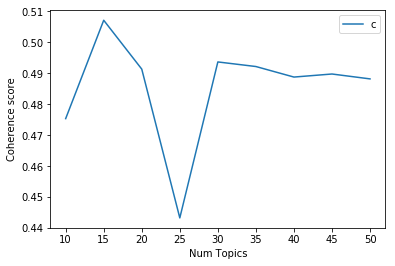

In [44]:
# Show graph
max_topics=50; start=10; step=5;
x = range(start, max_topics + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# The coherence score is highest on 15 topics
# However it is also the same amount of subcategories
# We want to have more topics than that. So 30 is a good opption
# The coherence score dop at 25 topics is quite strange

N_TOPICS = 30

In [30]:
%%time

# train lda model
lda_model, dictionary, corpus = train_pipline(df_train['tokenized'], N_TOPICS, retrain=True)

CPU times: user 3min 56s, sys: 66.6 ms, total: 3min 56s
Wall time: 1min 2s


In [32]:
lda_model.show_topics(num_topics=5, num_words=20, formatted=True)

[(4,
  '0.051*"kilpirauhasen" + 0.025*"vajaatoiminnan" + 0.011*"vajaatoiminta" + 0.011*"euro" + 0.009*"ncap" + 0.007*"dubai" + 0.006*"dubaissa" + 0.004*"volvo" + 0.004*"niron" + 0.003*"juurta" + 0.003*"venetsian" + 0.003*"toteamisesta" + 0.003*"alain" + 0.003*"juuren" + 0.003*"patja" + 0.003*"karita" + 0.003*"matot" + 0.003*"best" + 0.003*"amsterdam" + 0.002*"bottas"'),
 (0,
  '0.008*"audi" + 0.006*"keuhkosyövän" + 0.005*"mustikka" + 0.005*"mahalaukun" + 0.005*"linnut" + 0.005*"sportback" + 0.005*"suomessa" + 0.005*"maa" + 0.004*"keuhkosyöpä" + 0.004*"pähkinöitä" + 0.004*"talven" + 0.004*"lintujen" + 0.004*"kipsi" + 0.004*"pähkinät" + 0.004*"lintu" + 0.003*"tron" + 0.003*"avant" + 0.003*"kuusen" + 0.003*"suomen" + 0.003*"syödä"'),
 (12,
  '0.003*"tuli" + 0.003*"ihmiset" + 0.002*"sai" + 0.002*"äiti" + 0.002*"elämä" + 0.002*"suomen" + 0.002*"helsingin" + 0.002*"isä" + 0.002*"ihminen" + 0.002*"alkoi" + 0.001*"pitäisi" + 0.001*"lopulta" + 0.001*"mies" + 0.001*"elämän" + 0.001*"piti" + 0.00

In [31]:
lda_model.save('models/model.lda')

In [11]:
def evaluate_coherence(data, lda_model, corpus, dictionary):
    # Compute Perplexity
    # a measure of how good the model is. lower the better.
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

    # Compute Coherence Score, higer is better
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


In [52]:
%%time
evaluate_coherence(df_train['tokenized'], lda_model, corpus, dictionary)


Perplexity:  -10.107144777288838

Coherence Score:  0.5180880042662807
CPU times: user 59.6 s, sys: 292 ms, total: 59.9 s
Wall time: 29.3 s


# After Training

In [48]:
# load the saved model
lda_model = LdaModel.load('models/model.lda', mmap='r')
dictionary = corpora.Dictionary.load('models/dictionary.pkl')
# load the cleaned data
df = pd.read_json('data/data_cleaned.json')

### Now let visualize the topics

In [59]:
corpus = create_corpus(dictionary, df_clean['tokenized'])

In [65]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## Process results for query by keywords

### Ok, now we have the model, dictionary, word vectors. What else we need to do?
The plan is:

### Approach 1: Calculate similarity score
* Load the LDA model, dictionary
* Load the pretrained word vectors from FastText converted to gensim format
* Load the article data need to have prediction
* Load the saved json file **topic - keywords** extracted from the model to dataframe
* Clean the data if needed, with tokenzied words
* Create corpus from tokenized words and dictionary
* Create prediction for the corpus and LDA model
* Create **doc - topics** dataframe, save to json format
* Calculate the similarity score of query keyword with topic keywords by pretrained word2vec
* Get the list of topics has the highest scores
* Get the list of docs are most relevant to the topic
* Return the result


### Approach 2: Train a neural network as supervised task

*  Consider topics as gold label for the neural network model
*  Take list of topic keywords as the input
*  Train the model with Feed forward network and embedding layer


In [51]:
def save_topic_keywords(lda_model, n_words):
    """
    Save topic with its keywords distribution as json
    """
    topic_keywords = lda_model.show_topics(num_topics=-1, num_words=n_words, formatted=False)
    df_topics = pd.DataFrame(topic_keywords, columns=['topic_id', 'keywords'])
    df_topics.to_json('data/topics.json', orient='records')
    
    return df_topics

def save_doc_topics(df, lda_model, dictionary):
    """
    Save topic with its topics distribution as json
    """
    corpus = create_corpus(dictionary, df['tokenized'])
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
    df_doc_topics = pd.DataFrame(doc_topic_dist, columns=['topic_' + str(x) for x in range(N_TOPICS)])
    df_doc_topics.insert(loc=0, column='uuid', value=df['id'])
    # save this to the models
    df_doc_topics.to_csv('data/doc_topics.csv', index=False)
    
    return df_doc_topics

    

In [74]:
df_topics = save_topic_keywords(lda_model, 50)

In [52]:
df_doc_topics = save_doc_topics(df, lda_model, dictionary)

In [53]:
df_doc_topics.head()

,uuid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,QXJ0aWNsZTpjZDUwZDI5Mi1jYjk5LTRlZmYtYWVmNC0yZm...,0.042724,0.023630,0.000075,0.000251,0.000065,0.000093,0.000148,0.039949,0.000148,...,0.000262,0.033658,0.000084,0.034274,0.000102,0.000103,0.003250,0.443131,0.005510,0.084713
1,QXJ0aWNsZTo5OTQ0MjNkYy04ZTljLTQxZTItOGQyNy0xMT...,0.000068,0.000072,0.000069,0.000231,0.000060,0.005728,0.000136,0.000119,0.000136,...,0.000241,0.029914,0.000078,0.039052,0.000094,0.000094,0.000113,0.827827,0.000072,0.020712
2,QXJ0aWNsZTplNGZiM2EwOS01MTI2LTRkYTctYjEzOS1jYz...,0.000093,0.000099,0.000095,0.000316,0.000082,0.000117,0.000186,0.000163,0.207305,...,0.000330,0.046230,0.000106,0.000120,0.000129,0.000129,0.000154,0.463375,0.000099,0.273360
3,QXJ0aWNsZTphOTQyMzU3YS01OGRkLTQ2ZTQtOGIyNC1hZW...,0.000083,0.000088,0.000084,0.000281,0.000073,0.000104,0.000165,0.000144,0.000165,...,0.000293,0.000103,0.000094,0.031181,0.000114,0.003296,0.000137,0.614437,0.000088,0.092755
4,QXJ0aWNsZTpkZDllOTM3ZS1iZWE3LTQxMDEtODAwNS00MT...,0.000061,0.013003,0.000062,0.000208,0.000054,0.000077,0.000122,0.000107,0.020730,...,0.000217,0.111349,0.000070,0.007153,0.000085,0.000085,0.000101,0.793116,0.000065,0.000140


### Great! We have enough material for NN training